# ANALISE DOS DADOS DE VENDAS DAS LOJAS FAVORITAS : APLICANDO TESTE T e RESPONDENDO PERGUNTAS, USANDO PYSPARK

DESCRIÇÃO DO PROBLEMA

Neste projeto tenho um conjunto de dados do periodo  2013 a 2017 com informações sobre as vendas das  lojas Corporation Favorita, uma importante varejista de alimentos sediada no Equador. Os principais objetivos são:
a. Entender o impacto das promoções nas vendas das lojas Favorita que ela possa adaptar suas estratégias de marketing e impulsionar as vendas durante períodos específicos.
b. Responder  a perguntas analíticas importantes.
Ao alavancar dados históricos de vendas e informações suplementares relevantes, e fazer uma análise mais verticalizada dos dados pode-se  fornecer informações confiáveis que permitam à gestão das lojas Favorita melhorar as tomadas de decisão, otimizando o gerenciamento de estoque, alocando recursos e estratégias de marketing.
Para tanto utilizei o frameworks pyspark, bem como bibliotecas de visualizações. O projeto é composto de duas etapas, incluindo comprensão do negócio e compreensão e análise dos dados.Essa composição é parte inicial da estrutura de INTELIGENCIA ANALITICA DO BIG DATA PARA OS NEGÓCIOS.

In [37]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType, DateType, TimestampType, BooleanType
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
# Bibliotecas de visualização
import matplotlib.pyplot as plt 
import seaborn as sns

In [7]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [8]:
spark = (
    SparkSession 
    .builder 
    .master("local[*]") 
    .appName('testet_respostap') 
    .getOrCreate() )

24/07/31 09:33:19 WARN Utils: Your hostname, sc_oberdan resolves to a loopback address: 127.0.1.1; using 172.20.200.206 instead (on interface eth0)
24/07/31 09:33:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/31 09:33:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Carregar, Ler, visualizar e Checar Schema o dataset 

In [9]:
# Carregar, Ler, visualizar e Checar Schema do dataset holidays_events
path_vrf = ('./dados/test_favorita/vendas_resum_favorita.csv')

df_vrf = spark.read\
    .format("csv")\
    .option('sep', ',')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .csv(path_vrf)

print("Visualizando os dados :")
df_vrf.show(5)

print("Schema dos dados :")
df_vrf.printSchema()

Visualizando os dados :
+---+---+----------+---------+----------+-----+-----------+------------+----------+------------+--------+----------+------------------+-----------+
|_c0| id|      date|store_nbr|    family|sales|onpromotion|transactions|dcoilwtico|tipo_feriado| d_local|nome_local|         descricao|transferido|
+---+---+----------+---------+----------+-----+-----------+------------+----------+------------+--------+----------+------------------+-----------+
| 41|0.0|2013-01-01|      1.0|AUTOMOTIVE|  0.0|        0.0|        NULL|      NULL|     Holiday|National|   Ecuador|Primer dia del ano|      false|
| 42|1.0|2013-01-01|      1.0| BABY CARE|  0.0|        0.0|        NULL|      NULL|     Holiday|National|   Ecuador|Primer dia del ano|      false|
| 43|2.0|2013-01-01|      1.0|    BEAUTY|  0.0|        0.0|        NULL|      NULL|     Holiday|National|   Ecuador|Primer dia del ano|      false|
| 44|3.0|2013-01-01|      1.0| BEVERAGES|  0.0|        0.0|        NULL|      NULL|     

24/07/31 09:33:36 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, date, store_nbr, family, sales, onpromotion, transactions, dcoilwtico, tipo_feriado, d_local, nome_local, descricao, transferido
 Schema: _c0, id, date, store_nbr, family, sales, onpromotion, transactions, dcoilwtico, tipo_feriado, d_local, nome_local, descricao, transferido
Expected: _c0 but found: 
CSV file: file:///home/oberdan_admin/.vscode-server/pyspark_proj/pyspark_proj/dados/test_favorita/vendas_resum_favorita.csv


In [10]:
# Contagem de linhas e colunas do dataset df_vrf
linhas = df_vrf.count()
print(f"Contagem de linhas do DataFrame  : {linhas}")
colunas = len(df_vrf.columns)
print(f"Contagem de colunas do DataFrame : {colunas}")

Contagem de linhas do DataFrame  : 3054352
Contagem de colunas do DataFrame : 14


In [11]:
# Calculando  valores nulos do dataset df_vrf
df_vrf.select([F.count(F.when(F.isnull(c), c))\
          .alias(c) for c in df_vrf.columns]).show()

24/07/31 09:33:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, date, store_nbr, family, sales, onpromotion, transactions, dcoilwtico, tipo_feriado, d_local, nome_local, descricao, transferido
 Schema: _c0, id, date, store_nbr, family, sales, onpromotion, transactions, dcoilwtico, tipo_feriado, d_local, nome_local, descricao, transferido
Expected: _c0 but found: 
CSV file: file:///home/oberdan_admin/.vscode-server/pyspark_proj/pyspark_proj/dados/test_favorita/vendas_resum_favorita.csv


+---+---+----+---------+------+-----+-----------+------------+----------+------------+-------+----------+---------+-----------+
|_c0| id|date|store_nbr|family|sales|onpromotion|transactions|dcoilwtico|tipo_feriado|d_local|nome_local|descricao|transferido|
+---+---+----+---------+------+-----+-----------+------------+----------+------------+-------+----------+---------+-----------+
|  0|  4|   0|        4|     4|    4|          4|      249121|    955156|     2551824|2551824|   2551824|  2551824|    2551824|
+---+---+----+---------+------+-----+-----------+------------+----------+------------+-------+----------+---------+-----------+



In [13]:
# Crie uma cópia do dataframe para fazer os testes e  responder a perguntas
df_vrf1 = df_vrf.alias('df_vrf1')

TESTE DE HIPOTESES USANDO TESTE T E RESPONDENDO PERGUNTAS

Um teste t é parametrico que compara as médias de dois grupos de dados e informa se eles são significativamente diferentes um do outro. Como premissa, ele assume que os dados são normalmente distribuídos, que os grupos têm variâncias iguais e que as observações são independentes. Ele ajuda a avaliar se as diferenças observadas entre as médias da amostra dos grupos provavelmente ocorreram devido ao acaso ou se são estatisticamente significativas. Em outras palavras, ele no ajudará a determinar se as atividades promocionais impactaram significativamente as vendas da Corporation Favorita nas lojas.

Hipótese nula (H0): A intensidade da promoção (onpromotion) não tem um impacto significativo nas vendas médias dos produtos. 
Hipótese alternativa (H1): A intensidade da promoção (onpromotion) tem um impacto significativo nas vendas médias dos produtos.

In [14]:
# Dividir a variável onpromotion em produtos promovidos e produtos não promovidos
dados_prom = df_vrf1[df_vrf1['onpromotion'] >= 1]
dados_nao_prom = df_vrf1[df_vrf1['onpromotion'] < 1]
list_teste = dados_prom.select("onpromotion").rdd.flatMap(list).collect()
list_teste1 = dados_nao_prom.select("onpromotion").rdd.flatMap(list).collect()

In [15]:
# Calcular vendas médias para produtos promovidos e não promovidos
print("Médias de vendas para produtos promovidos:")
med_vend_prom = dados_prom.select(avg('sales')).show()
print("Médias de vendas médias para produtos não promovidos:")
med_vend_nao_prom = dados_nao_prom.select(avg('sales')).show()

Médias de vendas para produtos promovidos:


+------------------+
|        avg(sales)|
+------------------+
|1139.8286947893275|
+------------------+

Médias de vendas médias para produtos não promovidos:


+-----------------+
|       avg(sales)|
+-----------------+
|157.8104722009354|
+-----------------+



In [16]:
# Realizar um teste t com base nos valores de vendas
t_statistic, p_value = ttest_ind(list_teste, list_teste1)

# Determinar o nível de significância (alfa)
alpha = 0.05

# Verifique se o valor p é menor que o nível de significância
if p_value < alpha:
    result = "Rejeite a hipótese nula"
else:
    result = "Não rejeitar a hipótese nula"

# Imprima os resultados com o p_valor formatado com três casas decimais
print("T-estatistico:", t_statistic)
print(f"P-value: {p_value:.3f}")  # Format p-value to three decimal places
print("Conclusão:", result)

T-estatistico: 810.5602101213514
P-value: 0.000
Conclusão: Rejeite a hipótese nula


Notas
A média de vendas para produtos promovidos é de aproximadamente 1139,83. A média de vendas para produtos não promovidos é de aproximadamente 157,81. A estatística t calculada é de aproximadamente 810,56. O p_valor calculado é 0,000. A média de vendas para produtos promovidos é maior do que a média de vendas para produtos não promovidos

Com base no p_valor sendo significativamente menor do que o nível de significância de 0,05, podemos rejeitar a hipótese nula. Isso sugere que há uma diferença significativa entre as vendas médias de produtos promovidos e produtos não promovidos. Em outras palavras, a presença de promoções tem um efeito positivo estatisticamente significativo nas vendas de produtos.

Perguntas analíticas importantes

Pergunta 1: Quais datas têm as menores e maiores vendas em cada ano?

In [17]:
# Extrair ano da coluna 'date'
df_ano = df_vrf1.withColumn('ano', year(df_vrf1.date))
df_ano.show(5)

+---+---+----------+---------+----------+-----+-----------+------------+----------+------------+--------+----------+------------------+-----------+----+
|_c0| id|      date|store_nbr|    family|sales|onpromotion|transactions|dcoilwtico|tipo_feriado| d_local|nome_local|         descricao|transferido| ano|
+---+---+----------+---------+----------+-----+-----------+------------+----------+------------+--------+----------+------------------+-----------+----+
| 41|0.0|2013-01-01|      1.0|AUTOMOTIVE|  0.0|        0.0|        NULL|      NULL|     Holiday|National|   Ecuador|Primer dia del ano|      false|2013|
| 42|1.0|2013-01-01|      1.0| BABY CARE|  0.0|        0.0|        NULL|      NULL|     Holiday|National|   Ecuador|Primer dia del ano|      false|2013|
| 43|2.0|2013-01-01|      1.0|    BEAUTY|  0.0|        0.0|        NULL|      NULL|     Holiday|National|   Ecuador|Primer dia del ano|      false|2013|
| 44|3.0|2013-01-01|      1.0| BEVERAGES|  0.0|        0.0|        NULL|      NULL

24/07/31 09:35:36 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, date, store_nbr, family, sales, onpromotion, transactions, dcoilwtico, tipo_feriado, d_local, nome_local, descricao, transferido
 Schema: _c0, id, date, store_nbr, family, sales, onpromotion, transactions, dcoilwtico, tipo_feriado, d_local, nome_local, descricao, transferido
Expected: _c0 but found: 
CSV file: file:///home/oberdan_admin/.vscode-server/pyspark_proj/pyspark_proj/dados/test_favorita/vendas_resum_favorita.csv


In [18]:
# Agrupar por ano e calcular vendas mínimas e máximas
vendas_yearly = df_ano.groupby('ano').agg(min('sales').alias("venda_min"), max('sales').alias("vendas_max"))


In [19]:
# Encontre as datas com menores e maiores vendas para cada ano
print("\nDatas com menores vendas em cada ano:")
datas_menores_vendas = df_ano.groupby('ano').agg({'ano': 'min', 'date': 'min', 'sales':'min'}).show()
print("\nDatas com maiores vendas em cada ano:")
datas_maiores_vendas = df_ano.groupby('ano').agg({'ano': 'max', 'date': 'max', 'sales':'max'}).show()


Datas com menores vendas em cada ano:


+----+----------+--------+----------+
| ano| min(date)|min(ano)|min(sales)|
+----+----------+--------+----------+
|2013|2013-01-01|    2013|       0.0|
|2014|2014-01-01|    2014|       0.0|
|2015|2015-01-01|    2015|       0.0|
|2016|2016-01-01|    2016|       0.0|
|2017|2017-01-01|    2017|       0.0|
+----+----------+--------+----------+


Datas com maiores vendas em cada ano:


+----+----------+--------+----------+
| ano| max(date)|max(ano)|max(sales)|
+----+----------+--------+----------+
|2013|2013-12-31|    2013|   46271.0|
|2014|2014-12-31|    2014|   45361.0|
|2015|2015-12-31|    2015|  40351.46|
|2016|2016-12-31|    2016|  124717.0|
|2017|2017-08-15|    2017| 38422.625|
+----+----------+--------+----------+



Nota: Datas com vendas menores e maiores para cada ano
Vendas menores: 
Esses dados indicam que nas datas mencionadas, as vendas estavam no seu nível mais baixo, e o valor de vendas registrado para essas datas foi 0,0 para todos os anos (2013, 2014, 2015, 2016 e 2017). Isso pode ser devido a vários fatores, como feriados, eventos especiais ou outras circunstâncias que levaram a uma menor atividade de vendas nessas datas específicas.
Vendas maiores:
Notas Datas com maiores vendas para cada ano No ano de 2013, as maiores vendas de 46.271.000 ocorreram em 12 de novembro de 2013. No ano de 2014, as maiores vendas de 45.361.000 ocorreram em 8 de dezembro de 2014. No ano de 2015, as maiores vendas de 40.351.460 ocorreram em 14 de dezembro de 2015. No ano de 2016, as maiores vendas de 124.717.000 ocorreram em 2 de maio de 2016. No ano de 2017, as maiores vendas de 38.422.625 ocorreram em 2 de abril de 2017. Essas datas representam os dias com os maiores valores de vendas em cada ano respectivo. Essas informações podem ser valiosas para entender tendências no desempenho de vendas e identificar eventos ou promoções potencialmente impactantes que levaram a esses dias de altas vendas.

Pergunta 2: Quais lojas estão entre as 10 maiores em termos de vendas totais?

In [20]:
# Agrupar dados por número de loja e calcular o total de vendas para cada loja
loja_vendas = df_vrf1.groupby('store_nbr').agg(sum('sales').alias("Vendas"))

In [23]:
# Classifique as lojas por vendas totais em ordem decrescente e selecione as 10 principais
print("\nAs 10 maiores lojas em termos de vendas totais:")
top_10_stores = loja_vendas.sort(desc('Vendas'))


As 10 maiores lojas em termos de vendas totais:


In [24]:
top_10_stores.show(10)

+---------+--------------------+
|store_nbr|              Vendas|
+---------+--------------------+
|     44.0| 6.335613722999901E7|
|     45.0|    5.568902200246E7|
|     47.0|   5.2024475956001E7|
|      3.0| 5.153352813585101E7|
|     49.0|   4.4346822760066E7|
|     46.0|  4.28047272936452E7|
|     48.0|3.6741804099816486E7|
|     51.0| 3.360386127734601E7|
|      8.0|3.1124067145028986E7|
|     50.0|2.9273750996574305E7|
+---------+--------------------+
only showing top 10 rows



Nota:
A loja com número de loja 44 tem o maior valor total de vendas de aproximadamente 62.087.550, seguida pela loja com número de loja 45 com um valor total de vendas de aproximadamente 54.498.010. O menor total de vendas é a loja número 50. Essas informações nos dão insights sobre as lojas que geraram o maior total de vendas, nos ajudando a entender a distribuição das vendas entre as lojas de melhor desempenho.

Pergunta 3: Determinar se certos grupos de lojas vendem mais produtos

In [26]:
# Agrupe por cluster e calcule a média de vendas
med_vend_cidad = df_vrf1.groupby('nome_local').agg(avg('sales').alias("Vendas"))

In [28]:
# Classifique os cluster por média de vendas em ordem decrescente 
print("\nClassificação de Cluster em termos de médias vendas:")
top_vend_cidad = med_vend_cidad.sort(desc('Vendas'))
top_vend_cidad.show(10)


Classificação de Cluster em termos de médias vendas:


+--------------------+------------------+
|          nome_local|            Vendas|
+--------------------+------------------+
|             Salinas| 558.6629900715911|
|               Quito|436.48943825182386|
|            Cotopaxi|  427.235777607744|
|       Santo Domingo|424.58217165232315|
|           El Carmen|424.58217165232315|
|             Ecuador| 416.7510691031219|
|               Manta| 390.1218395313131|
|                Loja|388.01707893490465|
|Santo Domingo de ...| 387.7747267207491|
|         Santa Elena|380.30274759248016|
+--------------------+------------------+
only showing top 10 rows



Pergunta 4: Quais famílias de produtos foram as mais frequentemente compradas (Top 5)

In [39]:
# Agrupar dados por família e calcular o total de vendas para cada família
family_vendas = df_vrf1.groupby('family').agg(sum('sales').alias("Vendas_prod"))
family_vendas.show(10)

+-------------------+--------------------+
|             family|         Vendas_prod|
+-------------------+--------------------+
|     PREPARED FOODS|   8966728.108912507|
|HOME AND KITCHEN II|           1556511.0|
|         LADIESWEAR|            668542.0|
|    LAWN AND GARDEN|            559639.0|
|          GROCERY I| 3.508272979900001E8|
|          BABY CARE|             10330.0|
|            PRODUCE|1.2544796802496998E8|
|         AUTOMOTIVE|            566398.0|
|          BEVERAGES|         2.2166354E8|
|          HOME CARE|         1.6409522E7|
+-------------------+--------------------+
only showing top 10 rows



In [40]:
# Classifique as famílias por vendas totais em ordem decrescente e selecione as 5 principais
top_5_families = family_vendas.sort(desc('Vendas_prod'))

In [41]:
top_5_families.show(5)

+---------+--------------------+
|   family|         Vendas_prod|
+---------+--------------------+
|GROCERY I| 3.508272979900001E8|
|BEVERAGES|         2.2166354E8|
|  PRODUCE|1.2544796802496998E8|
| CLEANING|         9.9421019E7|
|    DAIRY|         6.5823605E7|
+---------+--------------------+
only showing top 5 rows



Nota:
A família "MERCADOS I" tem o maior total de vendas, seguida por "BEBIDAS", "PRODUTOS", "LIMPEZA" e "LATICÍNIOS". Essas famílias de produtos têm vendas totais significativamente maiores em comparação a outras famílias no conjunto de dados. Essas informações podem ser valiosas para entender as preferências do cliente e otimizar as ofertas de produtos nessas categorias de alto desempenho.

Pergunta 5: Existe alguma associação entre as vendas por promoções, preços do petróleo e transações?

In [42]:
# Remover as colunas irrelevantes
df_correla = df_vrf1.drop("_c0", "family", "id", "date", "store_nbr", "d_local", "nome_local", "descricao")

In [43]:
# Calculando  valores nulos do dataset df_vrf
df_correla.select([count(when(isnull(c), c))\
          .alias(c) for c in df_correla.columns]).show()

+-----+-----------+------------+----------+------------+-----------+
|sales|onpromotion|transactions|dcoilwtico|tipo_feriado|transferido|
+-----+-----------+------------+----------+------------+-----------+
|    4|          4|      249121|    955156|     2551824|    2551824|
+-----+-----------+------------+----------+------------+-----------+



Abordagens para lidar com dados ausentes

In [44]:
# AB1:Para vendas e onpromotion serão tratados, retirando os valores em ausentes
df_correla = df_correla.dropna(subset=["sales", "onpromotion"]) 

In [45]:
# AB2: Para transações, substituiremos os valores na por 0, pois isso significa que nenhuma transação foi registrada na data mencionada
# Crie uma instância SimpleImputer com a estratégia definida como 'constante' e fill_value definido como 0
df_correla = df_correla.fillna(0, subset=["transactions"])

In [46]:
# AB3: Utilizarei 'na.fill'. Este parâmetro será responsável por preencher os  valores ausentes do tipo de feriado e transferido
df_correla.na.fill("Not Holiday", "tipo_feriado")
df_correla.na.fill("False", "transferido")

DataFrame[sales: double, onpromotion: double, transactions: double, dcoilwtico: double, tipo_feriado: string, transferido: boolean]

In [47]:
# AB4:Imputando valores de NA com tendência central medida, usando média
imputer = Imputer(inputCols=["dcoilwtico"], outputCols=["imputed_dcoilwtico"]).setStrategy("mean")

# Ajuste e transforme o Imputer ao seu DataFrame. Isso significa que ele analisará os dados e calculará as estatísticas de imputação
df_base_cor = imputer.fit(df_correla).transform(df_correla)
df_base_cor.show()

+-----+-----------+------------+----------+------------+-----------+------------------+
|sales|onpromotion|transactions|dcoilwtico|tipo_feriado|transferido|imputed_dcoilwtico|
+-----+-----------+------------+----------+------------+-----------+------------------+
|  0.0|        0.0|         0.0|      NULL|     Holiday|      false| 68.01587436333057|
|  0.0|        0.0|         0.0|      NULL|     Holiday|      false| 68.01587436333057|
|  0.0|        0.0|         0.0|      NULL|     Holiday|      false| 68.01587436333057|
|  0.0|        0.0|         0.0|      NULL|     Holiday|      false| 68.01587436333057|
|  0.0|        0.0|         0.0|      NULL|     Holiday|      false| 68.01587436333057|
|  0.0|        0.0|         0.0|      NULL|     Holiday|      false| 68.01587436333057|
|  0.0|        0.0|         0.0|      NULL|     Holiday|      false| 68.01587436333057|
|  0.0|        0.0|         0.0|      NULL|     Holiday|      false| 68.01587436333057|
|  0.0|        0.0|         0.0|

DE POSSE DAS VARIAVEIS PARA ANALISE DE CORRELAÇÃO, INICIAREI COM SELEÇÃO DE RECURSOS E VETORIZAÇÃO 
Na análise de correlação usarei como base o coeficientes de correlação de Pearson. Para apoiar esse processo de analise é essencial focar em características relevantes. Como a ideia é ter recursos relevantes removerei algumas colunas irrelevantes do dataset.

In [48]:
# Removendo  colunas irrelevantes, pois não precisaremos delas Motivos 
df_matrix = df_base_cor.drop("dcoilwtico", "tipo_feriado", "transferido")

In [49]:
# Alterando os tipos das variavies
df_matrix1 = df_matrix.withColumn("onpromotion", df_matrix.onpromotion.cast('int'))
df_matrix2 = df_matrix1.withColumn("transactions", df_matrix1.transactions.cast('int'))
df_matrix3 = df_matrix2.withColumn("imputed_dcoilwtico", df_matrix2.imputed_dcoilwtico.cast('int'))
df_corr = df_matrix3.withColumn("sales", df_matrix3.sales.cast('int'))

In [50]:
df_corr.printSchema()

root
 |-- sales: integer (nullable = true)
 |-- onpromotion: integer (nullable = true)
 |-- transactions: integer (nullable = true)
 |-- imputed_dcoilwtico: integer (nullable = true)



Verificando a associações entre as variaveis

In [51]:
print("\nAssociação estatística entre vendas e promoções:")
df_corr.corr("onpromotion", "sales")


Associação estatística entre vendas e promoções:


0.42823064847725045

In [52]:
print("\nAssociação estatística entre vendas e transações:")
df_corr.corr("transactions", "sales")


Associação estatística entre vendas e transações:


0.23299669988067903

In [53]:
print("\nAssociação estatística entre vendas e preços do petroleo:")
df_corr.corr("imputed_dcoilwtico", "sales")


Associação estatística entre vendas e preços do petroleo:


-0.057356166525012985

In [54]:
# Selecionando recursos relevantes
sel_features = ["sales", "onpromotion", "transactions", "imputed_dcoilwtico"]
# Montar recursos em um vetor
assembler = VectorAssembler(inputCols=sel_features, outputCol="features")
vendas_vectorized = assembler.transform(df_corr.select(sel_features))

In [55]:
# Calcule matrix de Correlação Pearson correlation. O método .head() é usado aqui para obter uma saída mais legível para a primeira linha. 
matrix_cor_pearson = Correlation.corr(vendas_vectorized, "features", method="pearson").head()
matrix_cor_pearson

24/07/31 10:24:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Row(pearson(features)=DenseMatrix(4, 4, [1.0, 0.4282, 0.233, -0.0574, 0.4282, 1.0, 0.0513, -0.1374, 0.233, 0.0513, 1.0, -0.0466, -0.0574, -0.1374, -0.0466, 1.0], False))

Nota: A matriz de correlação é tipicamente uma matriz quadrada onde cada entrada representa o coeficiente de correlação entre duas variáveis. O coeficiente de correlação varia de –1 a 1. Quando está próximo de 1, significa que há uma forte correlação positiva; por exemplo, o valor mediano tende a subir quando o número de cômodos aumenta.

In [56]:
# Extraia a matriz de correlação como uma DenseMatrix
corr_values = matrix_cor_pearson[ 0 ].toArray() 
corr_values

array([[ 1.        ,  0.42823065,  0.2329967 , -0.05735617],
       [ 0.42823065,  1.        ,  0.05131412, -0.13737658],
       [ 0.2329967 ,  0.05131412,  1.        , -0.04661636],
       [-0.05735617, -0.13737658, -0.04661636,  1.        ]])

Visualizando a Matriz de Correlação

In [61]:
# Convertendo a matriz de correlação em um Pandas DataFrame
corr_matrix_pd = pd.DataFrame(corr_values, columns=sel_features, index=sel_features)

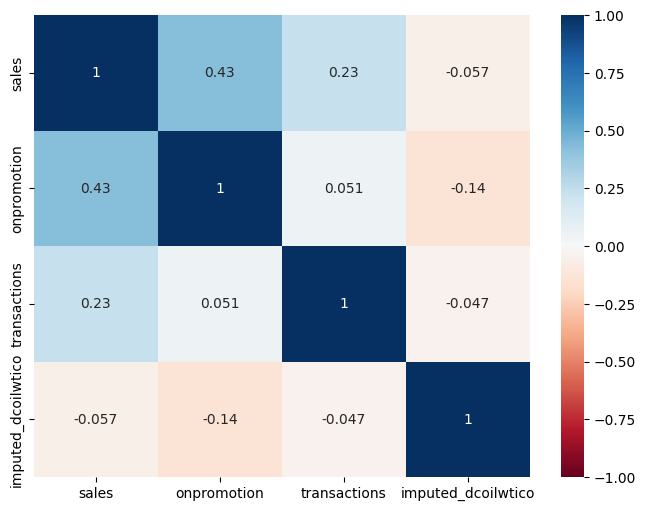

In [63]:
# Visualizando a Matriz de Correlação usando Seaborn e Matplotlib
plt.figure(figsize=( 8 , 6 )) 
heatmap = sns.heatmap(corr_matrix_pd, 
                      annot= True ,   # Mostra os valores numéricos das correlações
                       cmap= "RdBu" , 
                      vmin=- 1 , 
                      vmax= 1 ) 
plt.show()

Nota: Interpretação e Insights A matriz de correlação resultante fornece insights sobre como o Resultado de vendas, onpromotion, transactions e "imputed_dcoilwtico estão associados. Entre todas variaveis, a variavel promoção tem uma relação positiva moderada (r=0,4) com vendas. A variável preços do petroleo tem uma relação negativa(r=-0,05). A magnitude do coeficiente reflete a força da correlação